In [1]:
# ================================
# !!! DEGRADE IRF THROUGH AEFF !!!
# ================================

# IMPORTS ---!
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from module_plot import degradedIRF_3d
from module_analysis import degrade_IRF

import os
import sys
import subprocess

# check permissions ---!
if os.geteuid() == 0:
    print("We're root!")
else:
    print("We're not root.")

# setup ---!
pathout = '/usr/local/gamma/share/caldb/data/cta/degr3b/bcf/'
pathin = '/usr/local/gamma/share/caldb/data/cta/prod3b/bcf/'
folder = 'South_z40_average_100s/'
irf = pathin + folder + 'irf_file.fits'
degraded_irf = pathout + folder + 'irf_file.fits'

# load table ---!
degrade_IRF(irf, degraded_irf, factor=2)

with fits.open(irf) as hdul :
    aeff = hdul['EFFECTIVE AREA'].data['EFFAREA'][:]
    
with fits.open(degraded_irf) as hdul :
    aeff2 = hdul['EFFECTIVE AREA'].data['EFFAREA'][:]
    

We're not root.


(6, 42) (6, 42) (6, 42)


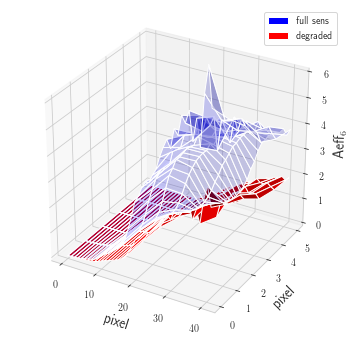

In [4]:
# ====================
# !!! PLOT AEFF 3D !!!
# ====================

from mpl_toolkits.mplot3d import Axes3D

savefig = 'IRF_degrading_Aeff.png'
fontsize=14
plt.rc('text', usetex=True)
sns.set_style("whitegrid", {'axes.grid' : False})

x = np.array(range(len(aeff[:][0])))
y = np.array(range(len(aeff[0][0][:])))
xx, yy = np.meshgrid(y, x)

aeff_flat = aeff[0]
aeff2_flat = aeff2[0]
print(xx.shape, yy.shape, aeff_flat.shape)

degradedIRF_3d(xx, yy, [aeff_flat/1e6, aeff2_flat/1e6], xlabel='pixel', ylabel='pixel', 
               zlabel='Aeff$_6$', title=None, fontsize=fontsize, zlim=(0,6), alpha=[0.2, 1], 
               c=['b', 'r'], label=['full sens', 'degraded'], savefig=savefig)


